In [26]:
from config import DATABASE_URI
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import io
import psycopg2

In [6]:
def get_images_from_db():
    #We connect to the local DB
    conn = psycopg2.connect(DATABASE_URI)
    
    cursor = conn.cursor()
    cursor.execute("SELECT fruit_name, image FROM fruits")
    
    #Stract all images binary information and also the fruit name into rows
    rows = cursor.fetchall()
    images, labels = [], []
    
    #loop throu each row and append image information in a np array into the list images
    for row in rows:
        
        fruit_name, binary_data = row
        image = Image.open(io.BytesIO(binary_data)).convert('RGB')
        # getting the image and resize to 224x224 and making sure is RGB for the model
        image = image.resize((224, 224))  # Resize to (224, 224)
        
        #append the image and the label into images and labels lists 
        images.append(np.array(image))
        labels.append(fruit_name)
        
    cursor.close()
    conn.close()
    return np.array(images), np.array(labels)

images, labels = get_images_from_db()
print(f'Retrieved {len(images)} images from the database.')

Retrieved 9678 images from the database.


In [7]:
# Normalize the images
images = images / 255.0

# Encode labels as integers
label_encoder = LabelEncoder()

labels = label_encoder.fit_transform(labels)
#split the images into 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# FOURTH MODEL TESTED

In [8]:
model_4 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(label_encoder.classes_), activation='softmax')
])

model_4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_4.summary()


c:\Users\Javier Alarcon\anaconda3\envs\dev\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,600,901 (9.92 MB)

 Trainable params: 2,600,901 (9.92 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Train the model
history = model_4.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 117s 479ms/step - accuracy: 0.3641 - loss: 1.4073 - val_accuracy: 0.5883 - val_loss: 1.0111
Epoch 2/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 113s 465ms/step - accuracy: 0.5887 - loss: 1.0161 - val_accuracy: 0.6193 - val_loss: 0.9514
Epoch 3/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 113s 467ms/step - accuracy: 0.6378 - loss: 0.9115 - val_accuracy: 0.6374 - val_loss: 0.9018
Epoch 4/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 113s 465ms/step - accuracy: 0.6691 - loss: 0.8204 - val_accuracy: 0.6560 - val_loss: 0.8880
Epoch 5/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 114s 470ms/step - accuracy: 0.7140 - loss: 0.7278 - val_accuracy: 0.6503 - val_loss: 0.9210
Epoch 6/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 114s 469ms/step - accuracy: 0.7737 - loss: 0.6044 - val_accuracy: 0.6431 - val_loss: 0.9664
Epoch 7/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 113s 468ms/step - accuracy: 0.8264 - loss: 0.4604 - val_accuracy: 0.6477 - val_loss: 1.0631
Epoch 8/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 113s 467ms/step - accuracy: 0.8783 -

In [10]:
# Save the model
model_4.save('NeuralNetwork_train_model/fruit_classifier_model_4.h5')

In [11]:
# Evaluate the model
test_loss, test_acc = model_4.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')

61/61 - 7s - 116ms/step - accuracy: 0.6534 - loss: 1.7477
Test accuracy: 0.6534090638160706


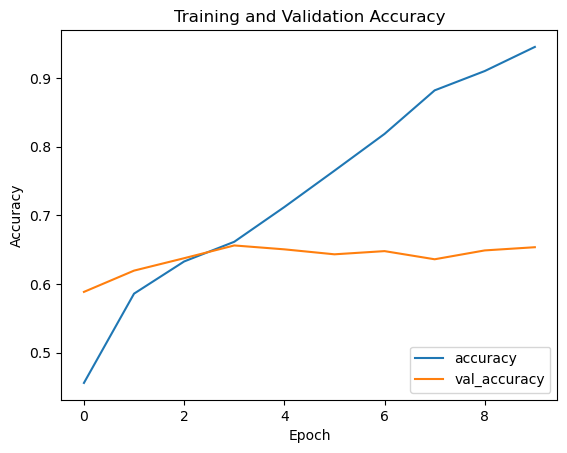

In [12]:
# Plot accuracy over epochs
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.savefig('Accuracy_Epoch_Graph_images/model_4')
plt.show()

61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step


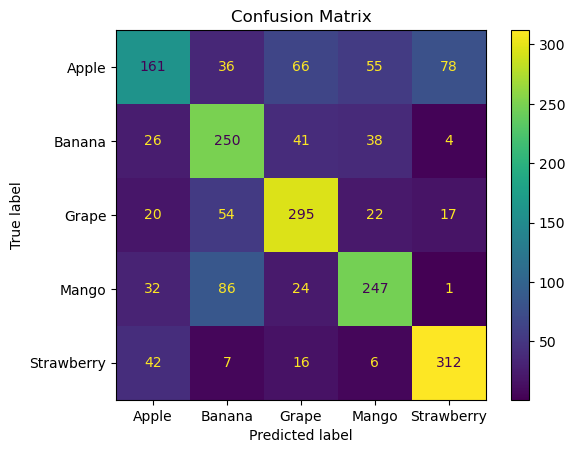

In [14]:
# Plot confusion matrix
y_pred = model_4.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)
cmd = ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_)
cmd.plot()
plt.title('Confusion Matrix')
plt.savefig('Confusion_matrix_images/model_4')
plt.show()

In [15]:
# Save the label encoder
import pickle

with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

In [16]:
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

       Apple       0.57      0.41      0.48       396
      Banana       0.58      0.70      0.63       359
       Grape       0.67      0.72      0.69       408
       Mango       0.67      0.63      0.65       390
  Strawberry       0.76      0.81      0.78       383

    accuracy                           0.65      1936
   macro avg       0.65      0.65      0.65      1936
weighted avg       0.65      0.65      0.65      1936



# FIFTH MODEL TESTED 

In [17]:
# Build and compile the model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)
model_5 = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model_5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [19]:
# Train the model
history_5 = model_5.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 93s 369ms/step - accuracy: 0.7243 - loss: 0.7475 - val_accuracy: 0.8580 - val_loss: 0.3795
Epoch 2/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 83s 341ms/step - accuracy: 0.8855 - loss: 0.3278 - val_accuracy: 0.8745 - val_loss: 0.3419
Epoch 3/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 82s 339ms/step - accuracy: 0.9190 - loss: 0.2273 - val_accuracy: 0.8714 - val_loss: 0.3538
Epoch 4/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 82s 339ms/step - accuracy: 0.9357 - loss: 0.1885 - val_accuracy: 0.8688 - val_loss: 0.3823
Epoch 5/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 84s 349ms/step - accuracy: 0.9465 - loss: 0.1576 - val_accuracy: 0.8729 - val_loss: 0.3820
Epoch 6/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 83s 341ms/step - accuracy: 0.9662 - loss: 0.1122 - val_accuracy: 0.8771 - val_loss: 0.3773
Epoch 7/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 83s 344ms/step - accuracy: 0.9791 - loss: 0.0802 - val_accuracy: 0.8791 - val_loss: 0.3876
Epoch 8/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 83s 342ms/step - accuracy: 0.9859 - loss: 0

In [20]:
# Evaluate the model
test_loss, test_acc = model_5.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')

61/61 - 17s - 272ms/step - accuracy: 0.8807 - loss: 0.4419
Test accuracy: 0.8806818127632141


In [21]:
# Save the model
model_5.save('NeuralNetwork_train_model/fruit_classifier_mobilenetv2_final.h5')

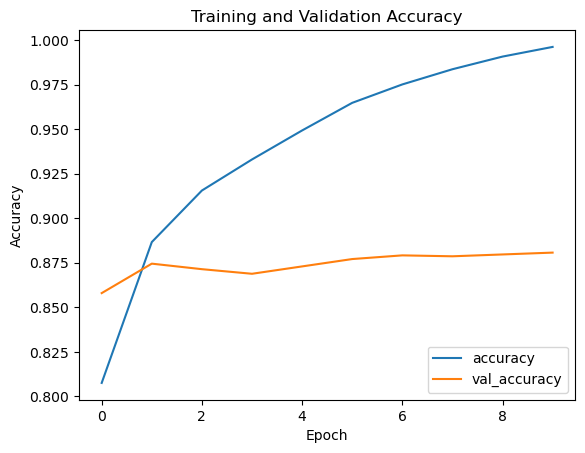

In [22]:
# Plot accuracy over epochs
plt.plot(history_5.history['accuracy'], label='accuracy')
plt.plot(history_5.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.savefig('Accuracy_Epoch_Graph_images/model_5')
plt.show()

61/61 ━━━━━━━━━━━━━━━━━━━━ 17s 280ms/step


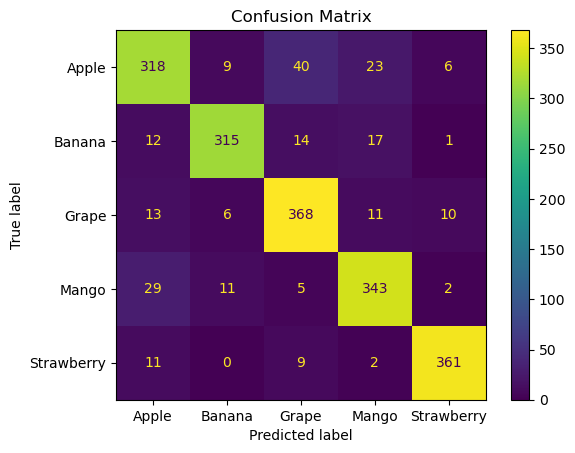

In [24]:
# Plot confusion matrix
y_pred_5 = model_5.predict(X_test)
y_pred_classes_5 = np.argmax(y_pred_5, axis=1)
cm = confusion_matrix(y_test, y_pred_classes_5)
cmd = ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_)
cmd.plot()
plt.title('Confusion Matrix')
plt.savefig('Confusion_matrix_images/model_5')
plt.show()

In [31]:
print(classification_report(y_test, y_pred_classes_5, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

       Apple       0.83      0.80      0.82       396
      Banana       0.92      0.88      0.90       359
       Grape       0.84      0.90      0.87       408
       Mango       0.87      0.88      0.87       390
  Strawberry       0.95      0.94      0.95       383

    accuracy                           0.88      1936
   macro avg       0.88      0.88      0.88      1936
weighted avg       0.88      0.88      0.88      1936

